In [1]:
import os
import xml.etree.ElementTree as ET
from torchvision.utils import save_image

import torch
import torchvision
import torch.nn as nn
#from .utils import load_state_dict_from_url
from torch.nn.utils import spectral_norm

# for testing only
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import os
from PIL import Image
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from PIL import Image
from tqdm import tqdm

import pandas as pd 
import numpy as np
from matplotlib.pyplot import imshow

from copy import deepcopy
import torchvision.utils as vutils
from torch.autograd import Variable

# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)


In [2]:

# Data augmentation and converting to tensors
random_transforms = [transforms.ColorJitter(),transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([ transforms.Resize(128),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.2),
                                 transforms.CenterCrop(128),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# Clone github repository with data
if os.path.isdir('dataset'):
    root_dir='./'
else:
    root_dir='./doggo_gan/'
    # Clone github repository with data
    if not os.path.isdir('./doggo-gan'):
      !git clone 'https://gitlab.com/isnob46/doggo_gan.git'


In [4]:
import time
def donetime(start=None):
  if start != None:
    if ((time.time() - start)/60) < 60:
      print('DONE (time {:4.2f} m)'.format((time.time() - start)/60))
    else:
      print('DONE (time {:4.2f} h)'.format((time.time() - start)/3600))
  else:
    print('\nDONE')
  return

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def show_batch_images(dataset,batch_size,title=''):
  fig, axs = plt.subplots(1, batch_size,figsize=(15, 3), dpi=80)
  for i in range(batch_size):
    n=randint(0,len(dataset))
    im,label=dataset[n]
    unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    im=unorm(im)
    axs[i].imshow(im.permute(1,2,0))
    axs[i].set_title(list(dataset.class_to_idx.keys())[label] )
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

loaded: 20580
classes: 120


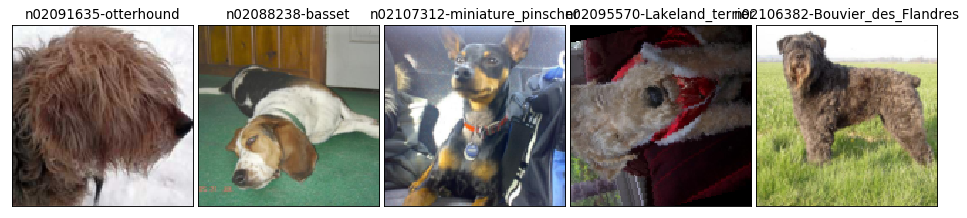

In [5]:
def doggo_loader(path):
    img = torchvision.datasets.folder.default_loader(path) # default loader
    
    # Get bounding box
    annotation_basename = os.path.splitext(os.path.basename(path))[0]
    annotation_dirname = next(dirname for dirname in os.listdir(root_dir+'dataset/annotation/') if dirname.startswith(annotation_basename.split('_')[0]))
    annotation_filename = os.path.join(root_dir+'dataset/annotation/', annotation_dirname, annotation_basename)
    tree = ET.parse(annotation_filename)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    bbox = (xmin, ymin, xmax, ymax)
    
    # return cropped image
    return img.crop(bbox)
    #return img

dataset = torchvision.datasets.ImageFolder(
    root_dir+'dataset/images',
    #loader=doggo_loader, # THE CUSTOM LOADER
    transform=transform
)

print('loaded:',len(dataset))
print('classes:',len(dataset.classes))
show_batch_images(dataset,5)




# GENERATOR AND DISCRIMINATOR

In [6]:
NUM_CLASSES=120
IMG_SIZE=128
LATENT_DIM=100


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(NUM_CLASSES, LATENT_DIM)

        self.init_size = IMG_SIZE // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(LATENT_DIM, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(3, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = IMG_SIZE // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, NUM_CLASSES), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity, label

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [7]:
BATCH_SIZE=64
EPOCH = 100 # play with me
LR_G = 0.0004
LR_D = 0.0005

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0

device = torch.device("cuda")
LR = 0.001
adversarial_loss = torch.nn.BCELoss().to(device)
auxiliary_loss = torch.nn.CrossEntropyLoss().to(device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

criterion = nn.BCELoss()

optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(beta1, 0.999))


G_losses = []
D_losses = []
epoch_time = []
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,batch_size=BATCH_SIZE, num_workers=4)

FloatTensor = torch.cuda.FloatTensor 
LongTensor = torch.cuda.LongTensor 

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, LATENT_DIM))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)



In [8]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        #gen_image = gen_image.numpy().transpose(1, 2, 0)
        unorm=UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        gen_image=unorm(gen_image)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize=(15, 3), dpi=80)
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = gen_im[index]
        axis.imshow(image_array.permute(1,2,0).cpu())
    plt.subplots_adjust(wspace=0, hspace=0)    
    plt.show()
    plt.close()

# TRAIN GAN

In [9]:
generator=torch.load('./generator128.pth')
discriminator=torch.load('./discriminator128.pth')   
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, LATENT_DIM))))
        gen_labels = Variable(LongTensor(np.random.randint(0, NUM_CLASSES, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()
        if i % 50 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
                % (epoch, epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
            )
        batches_done = epoch * len(dataloader) + i
        if batches_done % 200 == 0:
            sample_image(n_row=10, batches_done=batches_done)


C:\Users\isnob\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[Epoch 0/100] [Batch 0/322] [D loss: 2.618713, acc: 10%] [G loss: 2.964649]
[Epoch 0/100] [Batch 50/322] [D loss: 2.682572, acc: 12%] [G loss: 2.863446]
[Epoch 0/100] [Batch 100/322] [D loss: 2.686078, acc: 12%] [G loss: 3.020103]
[Epoch 0/100] [Batch 150/322] [D loss: 2.673614, acc: 8%] [G loss: 3.043274]
[Epoch 0/100] [Batch 200/322] [D loss: 2.655678, acc: 12%] [G loss: 2.773866]
[Epoch 0/100] [Batch 250/322] [D loss: 2.692312, acc: 13%] [G loss: 3.009742]
[Epoch 0/100] [Batch 300/322] [D loss: 2.702886, acc: 11%] [G loss: 2.930471]
[Epoch 1/100] [Batch 0/322] [D loss: 2.599291, acc: 10%] [G loss: 2.991175]
[Epoch 1/100] [Batch 50/322] [D loss: 2.640628, acc: 7%] [G loss: 2.960154]


RuntimeError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 8.00 GiB total capacity; 1.99 GiB already allocated; 222.06 MiB free; 827.12 MiB cached)

In [ ]:
torch.save(generator, 'generator128.pth')
torch.save(discriminator, 'discriminator128.pth')

In [ ]:
generator=torch.load('./generator.pth')
discriminator=torch.load('./discriminator.pth')   
n_row=5
batches_done='TEST'
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, LATENT_DIM))))
# Get labels ranging from 0 to n_classes for n rows
labels = np.array([num for _ in range(n_row) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)
save_image(gen_imgs.data, "images/%d.png" % 9999999999999999999, nrow=n_row, normalize=True)
